In [26]:
!pip install --quiet cirq
!pip install --quiet qiskit
import cirq
import fractions
import math
import random
import numpy as np
import pandas as pd
import sympy
from typing import Callable, List, Optional, Sequence, Union
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from fractions import Fraction
from qiskit import *
from qiskit.providers.jobstatus import JobStatus
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import MCMT
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import QFT
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit import Gate, Instruction, ParameterVector
from qiskit.test.mock import FakeVigo
import qiskit.providers.aer.noise as noise
from qiskit.visualization import plot_histogram
%matplotlib inline

In [27]:
def find_angles(a: int, n: int) -> np.ndarray:
    """Calculates the array of angles to be used in the addition in Fourier Space."""
    bits_little_endian = (bin(int(a))[2:].zfill(n))[::-1]

    angles = np.zeros(n)
    for i in range(n):
        for j in range(i + 1):
            k = i - j
            if bits_little_endian[j] == "1":
                angles[i] += pow(2, -k)

    return angles * np.pi

In [28]:
def double_controlled_phi_add_mod_N(
        angles: Union[np.ndarray, ParameterVector],
        c_phi_add_N: Gate,
        iphi_add_N: Gate,
        qft: Gate,
        iqft: Gate,
    ) -> QuantumCircuit:
    """Creates a circuit which implements double-controlled modular addition by a."""
    ctrl_qreg = QuantumRegister(2, "ctrl")
    b_qreg = QuantumRegister(len(angles), "b")
    flag_qreg = QuantumRegister(1, "flag")

    circuit = QuantumCircuit(ctrl_qreg, b_qreg, flag_qreg, name="ccphi_add_a_mod_N")

    cc_phi_add_a = phi_add_gate(angles).control(2)
    cc_iphi_add_a = cc_phi_add_a.inverse()

    circuit.append(cc_phi_add_a, [*ctrl_qreg, *b_qreg])

    circuit.append(iphi_add_N, b_qreg)

    circuit.append(iqft, b_qreg)
    circuit.cx(b_qreg[-1], flag_qreg[0])
    circuit.append(qft, b_qreg)

    circuit.append(c_phi_add_N, [*flag_qreg, *b_qreg])

    circuit.append(cc_iphi_add_a, [*ctrl_qreg, *b_qreg])

    circuit.append(iqft, b_qreg)
    circuit.x(b_qreg[-1])
    circuit.cx(b_qreg[-1], flag_qreg[0])
    circuit.x(b_qreg[-1])
    circuit.append(qft, b_qreg)

    circuit.append(cc_phi_add_a, [*ctrl_qreg, *b_qreg])

    return circuit


In [29]:
def controlled_multiple_mod_N(n: int, N: int, a: int, c_phi_add_N: Gate, iphi_add_N: Gate, qft: Gate, iqft: Gate) -> Instruction:
    """Implements modular multiplication by a as an instruction."""
    ctrl_qreg = QuantumRegister(1, "ctrl")
    x_qreg = QuantumRegister(n, "x")
    b_qreg = QuantumRegister(n + 1, "b")
    flag_qreg = QuantumRegister(1, "flag")

    circuit = QuantumCircuit(ctrl_qreg, x_qreg, b_qreg, flag_qreg, name="cmult_a_mod_N")

    angle_params = ParameterVector("angles", length=n + 1)
    modulo_adder = double_controlled_phi_add_mod_N(
        angle_params, c_phi_add_N, iphi_add_N, qft, iqft
    )

    def append_adder(adder: QuantumCircuit, constant: int, idx: int):
        partial_constant = (pow(2, idx, N) * constant) % N
        angles = find_angles(partial_constant, n + 1)
        bound = adder.assign_parameters({angle_params: angles})
        circuit.append(bound, [*ctrl_qreg, x_qreg[idx], *b_qreg, *flag_qreg])

    circuit.append(qft, b_qreg)

    # perform controlled addition by a on the aux register in Fourier space
    for i in range(n):
        append_adder(modulo_adder, a, i)

    circuit.append(iqft, b_qreg)

    # perform controlled subtraction by a in Fourier space on both the aux and down register
    for i in range(n):
        circuit.cswap(ctrl_qreg, x_qreg[i], b_qreg[i])

    circuit.append(qft, b_qreg)

    a_inv = pow(a, -1, mod=N) #if sys.version_info >= (3, 8) else self.modinv(a, N)

    modulo_adder_inv = modulo_adder.inverse()
    for i in reversed(range(n)):
        append_adder(modulo_adder_inv, a_inv, i)

    circuit.append(iqft, b_qreg)

    return circuit.to_instruction()

In [30]:
def phi_add_gate(angles: Union[np.ndarray, ParameterVector]) -> Gate:
    """Gate that performs addition by a in Fourier Space."""
    circuit = QuantumCircuit(len(angles))
    for i, angle in enumerate(angles):
        circuit.p(angle, i)
    return circuit.to_gate()

In [31]:
def power_mod_N(n: int, N: int, a: int) -> Instruction:
    """Implements modular exponentiation a^x mod N as an instruction."""
    exponent = QuantumRegister(2 * n, name="exponent")
    target = QuantumRegister(n, name="target")
    aux = QuantumRegister(n + 2, name="aux")

    circuit = QuantumCircuit(exponent, target, aux, name="Modular Exponentiation")

    qft = QFT(n + 1, do_swaps=False).to_gate()
    iqft = qft.inverse()

    # Create gates to perform addition/subtraction by N in Fourier Space
    phi_add_N = phi_add_gate(find_angles(N, n + 1))
    iphi_add_N = phi_add_N.inverse()
    c_phi_add_N = phi_add_N.control(1)

    # Apply the multiplication gates as showed in
    # the report in order to create the exponentiation
    for i in range(2 * n):
        partial_a = pow(a, pow(2, i), N)
        modulo_multiplier = controlled_multiple_mod_N(
            n, N, partial_a, c_phi_add_N, iphi_add_N, qft, iqft
        )
        circuit.append(modulo_multiplier, [exponent[i], *target, *aux])

    return circuit.to_instruction()

In [32]:
# Find Order Quantum Circuit.
def create_orderfind_circuit(a: int, N: int, verbose: bool = True):
    """
    Returns quantum circuit which computes the order of a modulo N.

    This function computes an eigenvalue of the unitary using Phase Estimation, which internally using Quantum Fourier Transform.
    """
    n = N.bit_length()
    
    # quantum register where the sequential QFT is performed
    exponent = QuantumRegister(2 * n, name="exponent")
    # quantum register where the multiplications are made
    target = QuantumRegister(n, name="target")
    # auxiliary quantum register used in addition and multiplication
    aux = QuantumRegister(n + 2, name="aux")
    
    # Create Quantum Circuit
    circuit = QuantumCircuit(exponent, target, aux)
    
    # Create maximal superposition in top register
    circuit.h(exponent)

    # Initialize down register to 1
    circuit.x(target[0])

    # Apply modulo exponentiation
    modular_exponentiation = power_mod_N(n, N, a)
    circuit.append(modular_exponentiation, circuit.qubits)

    # Apply inverse QFT
    iqft = QFT(len(exponent)).inverse().to_gate()
    circuit.append(iqft, exponent)
    
    reg = ClassicalRegister(2 * n, name="m")
    circuit.add_register(reg)
    circuit.measure(exponent, reg)

    if verbose:
        print(circuit)

    return circuit

In [33]:
# Continued Fraction Algorithm 
def continued_fraction_algorithm(frequencies: cirq.Result, a: int, N: int) -> Optional[int]:
    """
    Applied Continued Fraction  to obtain r from various k/r (output of find order).
    """
    # Read the output integer of the exponent register.
    s = list(frequencies.keys())[0]
    exponent = int(s,2)
    exp_num_bits = len(s)
    phase = float(exponent / 2 ** exp_num_bits)

    # Run the continued fractions algorithm to determine f = k / r.
    f = fractions.Fraction.from_float(phase).limit_denominator(N)
    
    # If the numerator is zero, the order finder failed.
    if f.numerator == 0:
        return None
    
    # Else, return the denominator if it is valid.
    r = f.denominator

    if a**r % N != 1:
        return None
    return r

In [34]:
# Find Order.
def find_order(a: int, N: int, verbose:bool = True) -> Optional[int]:
    """
    Finds smallest positive r such that a**r mod N == 1.
    """

    # Check that the integer a is a valid element of the multiplicative group modulo N.
    if a < 2 or N <= a or math.gcd(a, N) > 1:
        raise ValueError(f'Find Order failed due to invalid a={a} and modulus N={N}.')
    # Create the order finding circuit.
    circuit = create_orderfind_circuit(a, N, verbose)
    
    # Sample from the order finding circuit.
    backend = Aer.get_backend('aer_simulator')
    circ = transpile(circuit, backend)
    qobj = assemble(circ)
    measurement = backend.run(qobj, shots = 1).result()
    frequencies = measurement.get_counts()
    
    # Return the processed measurement result.
    r = continued_fraction_algorithm(frequencies, a, N)
    return r

In [37]:
# Find factor if it is a power of prime.
def find_factor_of_prime_power(N: int) -> Optional[int]:
    """
    Returns non-trivial factor of n if n is a prime power, else None.
    """
    for k in range(2, math.floor(math.log2(N)) + 1):
        c = math.pow(N, 1 / k)
        c1 = math.floor(c)
        if c1**k == N:
            return c1
        c2 = math.ceil(c)
        if c2**k == N:
            return c2
    return None

def num_occurrences(N: int, f: int) -> int:
    """
    Returns the number of occurences of the factor f of n.
    """
    count = 1
    f_power = f * f
    while (N % f_power == 0):
        count += 1
        f_power *= f

    return count

# Overall Function
def find_factor(N: int, verbose: bool = True, max_attempts: int = 25) -> Optional[tuple]:
    """
    Returns a non-trivial factor of integer n.
    """
    # If the number is prime, there are no non-trivial factors.
    if sympy.isprime(N):
        return (N, 1)
    
    # If the number is even, two is a non-trivial factor.
    if N % 2 == 0:
        return (2, num_occurrences(N, 2))
    
    # If n is a prime power, we can find a non-trivial factor efficiently.
    p = find_factor_of_prime_power(N)
    if p is not None:
        return (p, num_occurrences(N, p))
    
    for _ in range(max_attempts):
        # Choose a random number between 2 and n - 1.
        a = random.randint(2, N - 1)
        
        # Most likely a and n will be relatively prime.
        d = math.gcd(a, N)
        
        # If a and n are not relatively prime, we found a non-trivial factor.
        if 1 < d < n:
            return (d, num_occurrences(N, d))
        
        # Compute the order r of a modulo n using the order finder.
        r = find_order(a, N, verbose)
        
        # If the order finder failed, try again.
        if r is None:
            continue
        
        # If the order r is not even, try again.
        if r % 2 != 0:
            continue
        
        # Compute the non-trivial factor.
        x = (a ** (r // 2) - 1) % N
        d = math.gcd(x, N)
        if 1 < d < n:
            return (d, num_occurrences(N, d))

    if verbose:
        print(f"Failed to find a non-trivial factor in {max_attempts} attempts.")
    return (None, None)

def runMainCircuit(N: int = -1, verbose: bool = True, max_attempts: int = 25) -> tuple:
    """
    Returns Shor's Algorithm.
    """
    
    start = time.time()

    # Taking the input n from the user
    if(N == -1):
        N = int(input("Enter N: "))
    elif verbose:
        print('N: ', N)

    factors_with_power = []

    answer_found = False

    # Find all the factors of n.
    while(1):
        (f, pow) = find_factor(N, verbose, max_attempts)

        # If the algorithm is not able to find after the max repetitions.
        if f is None:
            break

        factors_with_power.append((f, pow))
        
        # If n is completely factorized return.
        if (f**pow) == N:
            answer_found = True
            break

        N = N // (f ** pow)

    end = time.time()

    if verbose and answer_found:
        print("Factors:")
        print(factors_with_power)

    return (end - start, answer_found)

# Simulator Test Main Circuit

In [38]:
# Number to factor
N = 10

# Attempt to find a factor
(time_taken, answer_found) = runMainCircuit(N, True)
print('Time taken: ', time_taken)

N:  10
Factors:
[(2, 1), (5, 1)]
Time taken:  9.989738464355469e-05


In [12]:
# Number to factor
N = 15

# Attempt to find a factor
(time_taken, answer_found) = runMainCircuit(N, True)
print('Time taken: ', time_taken)

n:  15
            ┌───┐┌──────────────────────────┐┌───────┐┌─┐                     
exponent_0: ┤ H ├┤0                         ├┤0      ├┤M├─────────────────────
            ├───┤│                          ││       │└╥┘┌─┐                  
exponent_1: ┤ H ├┤1                         ├┤1      ├─╫─┤M├──────────────────
            ├───┤│                          ││       │ ║ └╥┘┌─┐               
exponent_2: ┤ H ├┤2                         ├┤2      ├─╫──╫─┤M├───────────────
            ├───┤│                          ││       │ ║  ║ └╥┘┌─┐            
exponent_3: ┤ H ├┤3                         ├┤3      ├─╫──╫──╫─┤M├────────────
            ├───┤│                          ││  IQFT │ ║  ║  ║ └╥┘┌─┐         
exponent_4: ┤ H ├┤4                         ├┤4      ├─╫──╫──╫──╫─┤M├─────────
            ├───┤│                          ││       │ ║  ║  ║  ║ └╥┘┌─┐      
exponent_5: ┤ H ├┤5                         ├┤5      ├─╫──╫──╫──╫──╫─┤M├──────
            ├───┤│                          │

In [68]:
# Number to factor
N = 21

# Attempt to find a factor
(time_taken, answer_found) = runMainCircuit(N, True)
print('Time taken: ', time_taken)

n:  21
            ┌───┐┌──────────────────────────┐┌───────┐┌─┐                     »
exponent_0: ┤ H ├┤0                         ├┤0      ├┤M├─────────────────────»
            ├───┤│                          ││       │└╥┘┌─┐                  »
exponent_1: ┤ H ├┤1                         ├┤1      ├─╫─┤M├──────────────────»
            ├───┤│                          ││       │ ║ └╥┘┌─┐               »
exponent_2: ┤ H ├┤2                         ├┤2      ├─╫──╫─┤M├───────────────»
            ├───┤│                          ││       │ ║  ║ └╥┘┌─┐            »
exponent_3: ┤ H ├┤3                         ├┤3      ├─╫──╫──╫─┤M├────────────»
            ├───┤│                          ││       │ ║  ║  ║ └╥┘┌─┐         »
exponent_4: ┤ H ├┤4                         ├┤4      ├─╫──╫──╫──╫─┤M├─────────»
            ├───┤│                          ││  IQFT │ ║  ║  ║  ║ └╥┘┌─┐      »
exponent_5: ┤ H ├┤5                         ├┤5      ├─╫──╫──╫──╫──╫─┤M├──────»
            ├───┤│               

# Test only the Quantum Portion of Order Finding

In [11]:
# Find Order.
def find_order_backend(a: int, N: int, backend, verbose:bool = True) -> Optional[int]:
    """
    Finds smallest positive r such that a**r mod N == 1.
    """

    # Check that the integer a is a valid element of the multiplicative group modulo N.
    if a < 2 or N <= a or math.gcd(a, N) > 1:
        raise ValueError(f'Find Order failed due to invalid a={a} and modulus N={N}.')
    # Create the order finding circuit.
    circuit = create_orderfind_circuit(a, N, verbose)
    
    # Sample from the order finding circuit.
    circ = transpile(circuit, backend)
    qobj = assemble(circ)
    measurement = backend.run(qobj, shots = 1).result()
    frequencies = measurement.get_counts()
    
    # Return the processed measurement result.
    r = continued_fraction_algorithm(frequencies, a, N)
    return r

In [12]:
def runQuantumCircuit(a: int = -1, N: int = -1, backend = Aer.get_backend('aer_simulator'), verbose: bool = True, max_attempts: int = 25) -> tuple:
    """
    Runs the Quantum Circuit Portion
    """
    start = time.time()
    
    answer_found = False
    attempt = 1
    # Simulator Runs
    while attempt <= max_attempts and answer_found == False:
        r = find_order_backend(a, N, backend, verbose)
        if r is not None:
            answer_found = True
        else:
            attempt = attempt + 1
    
    end = time.time()
    avg_quant_time = (end - start) / attempt
    quant_r = r

    return (quant_r, avg_quant_time, end - start)

# Simulator Correctness

In [15]:
(r, avg_sim_time, tot_sim_time) = runQuantumCircuit(2, 3)
if r is not None:
    print('Simulation r: ', r)
else:
    print('Simulation failed. Increase max attempts.')

            ┌───┐┌─────────────────────────┐┌───────┐┌─┐         
exponent_0: ┤ H ├┤0                        ├┤0      ├┤M├─────────
            ├───┤│                         ││       │└╥┘┌─┐      
exponent_1: ┤ H ├┤1                        ├┤1      ├─╫─┤M├──────
            ├───┤│                         ││  IQFT │ ║ └╥┘┌─┐   
exponent_2: ┤ H ├┤2                        ├┤2      ├─╫──╫─┤M├───
            ├───┤│                         ││       │ ║  ║ └╥┘┌─┐
exponent_3: ┤ H ├┤3                        ├┤3      ├─╫──╫──╫─┤M├
            ├───┤│                         │└───────┘ ║  ║  ║ └╥┘
  target_0: ┤ X ├┤4                        ├──────────╫──╫──╫──╫─
            └───┘│  Modular Exponentiation │          ║  ║  ║  ║ 
  target_1: ─────┤5                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_0: ─────┤6                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_1

In [16]:
(r, avg_sim_time, tot_sim_time) = runQuantumCircuit(3, 5)
if r is not None:
    print('Simulation r: ', r)
else:
    print('Simulation failed. Increase max attempts.')

            ┌───┐┌──────────────────────────┐┌───────┐┌─┐               
exponent_0: ┤ H ├┤0                         ├┤0      ├┤M├───────────────
            ├───┤│                          ││       │└╥┘┌─┐            
exponent_1: ┤ H ├┤1                         ├┤1      ├─╫─┤M├────────────
            ├───┤│                          ││       │ ║ └╥┘┌─┐         
exponent_2: ┤ H ├┤2                         ├┤2      ├─╫──╫─┤M├─────────
            ├───┤│                          ││  IQFT │ ║  ║ └╥┘┌─┐      
exponent_3: ┤ H ├┤3                         ├┤3      ├─╫──╫──╫─┤M├──────
            ├───┤│                          ││       │ ║  ║  ║ └╥┘┌─┐   
exponent_4: ┤ H ├┤4                         ├┤4      ├─╫──╫──╫──╫─┤M├───
            ├───┤│                          ││       │ ║  ║  ║  ║ └╥┘┌─┐
exponent_5: ┤ H ├┤5                         ├┤5      ├─╫──╫──╫──╫──╫─┤M├
            ├───┤│                          │└───────┘ ║  ║  ║  ║  ║ └╥┘
  target_0: ┤ X ├┤6                         ├──────

In [17]:
(r, avg_sim_time, tot_sim_time) = runQuantumCircuit(7, 15)
if r is not None:
    print('Simulation r: ', r)
else:
    print('Simulation failed. Increase max attempts.')

            ┌───┐┌──────────────────────────┐┌───────┐┌─┐                     
exponent_0: ┤ H ├┤0                         ├┤0      ├┤M├─────────────────────
            ├───┤│                          ││       │└╥┘┌─┐                  
exponent_1: ┤ H ├┤1                         ├┤1      ├─╫─┤M├──────────────────
            ├───┤│                          ││       │ ║ └╥┘┌─┐               
exponent_2: ┤ H ├┤2                         ├┤2      ├─╫──╫─┤M├───────────────
            ├───┤│                          ││       │ ║  ║ └╥┘┌─┐            
exponent_3: ┤ H ├┤3                         ├┤3      ├─╫──╫──╫─┤M├────────────
            ├───┤│                          ││  IQFT │ ║  ║  ║ └╥┘┌─┐         
exponent_4: ┤ H ├┤4                         ├┤4      ├─╫──╫──╫──╫─┤M├─────────
            ├───┤│                          ││       │ ║  ║  ║  ║ └╥┘┌─┐      
exponent_5: ┤ H ├┤5                         ├┤5      ├─╫──╫──╫──╫──╫─┤M├──────
            ├───┤│                          ││      

# Noisy Simulators

In [ ]:
IBMQ.save_account('b5bbcda1a0eff0449582c42c04c3e1339b7d6af1ab309ffd16a8c573da617096454904a5983830ad7cfe7c2f554214b07ae5b642a9603d66dd91404a6cbb5db2')
provider = IBMQ.load_account()
backends = [Aer.get_backend('aer_simulator'),
            provider.backend.simulator_mps,
            provider.backend.simulator_statevector,
            provider.backend.ibmq_qasm_simulator]

verbose = True
for backend in backends:
    print(backend)
    (r, avg_sim_time, tot_sim_time) = runQuantumCircuit(2, 3, backend, verbose)
    if r is not None:
        print('Simulation r: ', r)
    else:
        print('Simulation failed. Increase max attempts.')


# Noise Model

In [13]:
# Find Order.
def find_order_noise_model(a: int, N: int, withNoise = True, verbose:bool = True) -> Optional[int]:
    """
    Finds smallest positive r such that x**r mod n == 1.
    """

    # Check that the integer a is a valid element of the multiplicative group modulo N.
    if a < 2 or N <= a or math.gcd(a, N) > 1:
        raise ValueError(f'Find Order failed due to invalid a={a} and modulus N={N}.')
    
    # Create the order finding circuit.
    circuit = create_orderfind_circuit(a, N, verbose)
    
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend('aer_simulator')
    
    if withNoise:
        # Error probabilities
        prob_1 = 0.001  # 1-qubit gate
        prob_2 = 0.01   # 2-qubit gate

        # Depolarizing quantum errors
        error_1 = noise.depolarizing_error(prob_1, 1)
        error_2 = noise.depolarizing_error(prob_2, 2)

        # Add errors to noise model
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
        print(noise_model)

        # Get basis gates from noise model
        basis_gates = noise_model.basis_gates

        # Perform a noise simulation
        result = execute(circuit, simulator,
                     basis_gates=basis_gates,
                     noise_model=noise_model).result()
    else:
        # Execute noisy simulation and get counts
        result = execute(circuit, simulator).result()
        
    # Sample from the order finding circuit.
    frequencies = result.get_counts(0)
    
    # Return the processed measurement result.
    r = continued_fraction_algorithm(frequencies, a, N)
    return r

In [14]:
def runQuantumCircuit(x: int = -1, n: int = -1, withNoise = True, verbose: bool = True, max_attempts: int = 25) -> tuple:
    """
    Runs the Quantum Circuit Portion
    """
    start = time.time()
    
    answer_found = False
    attempt = 1
    # Simulator Runs
    while attempt <= max_attempts and answer_found == False:
        r = find_order_noise_model(x, n, withNoise, verbose)
        if r is not None:
            answer_found = True
        else:
            attempt = attempt + 1
    
    end = time.time()
    avg_quant_time = (end - start) / attempt
    quant_r = r

    return (quant_r, avg_quant_time, end - start)

In [15]:
print('Without Noise')
(r, avg_sim_time, tot_sim_time) = runQuantumCircuit(2, 3, False)
if r is not None:
    print('Simulation r: ', r)
else:
    print('Simulation failed. Increase max attempts.')
    
print('With Noise')
(r, avg_sim_time, tot_sim_time) = runQuantumCircuit(2, 3, True)
if r is not None:
    print('Simulation r: ', r)
else:
    print('Simulation failed. Increase max attempts.')


Without Noise
            ┌───┐┌─────────────────────────┐┌───────┐┌─┐         
exponent_0: ┤ H ├┤0                        ├┤0      ├┤M├─────────
            ├───┤│                         ││       │└╥┘┌─┐      
exponent_1: ┤ H ├┤1                        ├┤1      ├─╫─┤M├──────
            ├───┤│                         ││  IQFT │ ║ └╥┘┌─┐   
exponent_2: ┤ H ├┤2                        ├┤2      ├─╫──╫─┤M├───
            ├───┤│                         ││       │ ║  ║ └╥┘┌─┐
exponent_3: ┤ H ├┤3                        ├┤3      ├─╫──╫──╫─┤M├
            ├───┤│                         │└───────┘ ║  ║  ║ └╥┘
  target_0: ┤ X ├┤4                        ├──────────╫──╫──╫──╫─
            └───┘│  Modular Exponentiation │          ║  ║  ║  ║ 
  target_1: ─────┤5                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_0: ─────┤6                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║ 

            ┌───┐┌─────────────────────────┐┌───────┐┌─┐         
exponent_0: ┤ H ├┤0                        ├┤0      ├┤M├─────────
            ├───┤│                         ││       │└╥┘┌─┐      
exponent_1: ┤ H ├┤1                        ├┤1      ├─╫─┤M├──────
            ├───┤│                         ││  IQFT │ ║ └╥┘┌─┐   
exponent_2: ┤ H ├┤2                        ├┤2      ├─╫──╫─┤M├───
            ├───┤│                         ││       │ ║  ║ └╥┘┌─┐
exponent_3: ┤ H ├┤3                        ├┤3      ├─╫──╫──╫─┤M├
            ├───┤│                         │└───────┘ ║  ║  ║ └╥┘
  target_0: ┤ X ├┤4                        ├──────────╫──╫──╫──╫─
            └───┘│  Modular Exponentiation │          ║  ║  ║  ║ 
  target_1: ─────┤5                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_0: ─────┤6                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_1

            ┌───┐┌─────────────────────────┐┌───────┐┌─┐         
exponent_0: ┤ H ├┤0                        ├┤0      ├┤M├─────────
            ├───┤│                         ││       │└╥┘┌─┐      
exponent_1: ┤ H ├┤1                        ├┤1      ├─╫─┤M├──────
            ├───┤│                         ││  IQFT │ ║ └╥┘┌─┐   
exponent_2: ┤ H ├┤2                        ├┤2      ├─╫──╫─┤M├───
            ├───┤│                         ││       │ ║  ║ └╥┘┌─┐
exponent_3: ┤ H ├┤3                        ├┤3      ├─╫──╫──╫─┤M├
            ├───┤│                         │└───────┘ ║  ║  ║ └╥┘
  target_0: ┤ X ├┤4                        ├──────────╫──╫──╫──╫─
            └───┘│  Modular Exponentiation │          ║  ║  ║  ║ 
  target_1: ─────┤5                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_0: ─────┤6                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_1

            ┌───┐┌─────────────────────────┐┌───────┐┌─┐         
exponent_0: ┤ H ├┤0                        ├┤0      ├┤M├─────────
            ├───┤│                         ││       │└╥┘┌─┐      
exponent_1: ┤ H ├┤1                        ├┤1      ├─╫─┤M├──────
            ├───┤│                         ││  IQFT │ ║ └╥┘┌─┐   
exponent_2: ┤ H ├┤2                        ├┤2      ├─╫──╫─┤M├───
            ├───┤│                         ││       │ ║  ║ └╥┘┌─┐
exponent_3: ┤ H ├┤3                        ├┤3      ├─╫──╫──╫─┤M├
            ├───┤│                         │└───────┘ ║  ║  ║ └╥┘
  target_0: ┤ X ├┤4                        ├──────────╫──╫──╫──╫─
            └───┘│  Modular Exponentiation │          ║  ║  ║  ║ 
  target_1: ─────┤5                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_0: ─────┤6                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_1

# Compare the results as phase and r for noise and without noise

In [16]:
# Continued Fraction Algorithm 
def print_phase_distribution(counts: cirq.Result, a: int, N: int, correctr: int, verbose:bool = True) -> Optional[int]:
    """
    Applied Continued Fraction  to obtain r from various k/r (output of find order).
    """
    if verbose:
        plt.bar(counts.keys(), counts.values(), color='g')
        plt.xticks(rotation=90)
        plt.show()
    
    rows, measured_phases = [], []
    total = 0
    correct = 0
    
    for output in counts:
        n_count = len(output)
        decimal = int(output, 2)  # Convert (base 2) string to decimal
        phase = decimal / (2**n_count)  # Find corresponding eigenvalue
        measured_phases.append(phase)
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        
        if r == correctr:
            correct += counts[output]
        total += counts[output]
        
        # Add these values to the rows in our table:
        rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                     f"{decimal}/{2**n_count} = {phase:.2f}",
                     f"{frac.numerator}/{frac.denominator}", r, counts[output]])
    
    if verbose:
        # Print the rows in a table
        headers=["Register Output", "Phase", "Fraction", "Guess for r", "Count"]
        df = pd.DataFrame(rows, columns=headers)
        print(df)
        print('-------------------------------------')
    
    return float(correct / total)

In [24]:
# Find Order.
def find_order_noise_model(a: int, N: int, r: int,  prob_1 = 0, prob_2 = 0, verbose:bool = True) -> Optional[int]:
    """
    Finds smallest positive r such that x**r mod n == 1.
    """

    # Check that the integer a is a valid element of the multiplicative group modulo N.
    if a < 2 or N <= a or math.gcd(a, N) > 1:
        raise ValueError(f'Find Order failed due to invalid a={a} and modulus N={N}.')
    
    # Create the order finding circuit.
    circuit = create_orderfind_circuit(a, N, verbose)
    
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend('aer_simulator')
    
    withNoise = (prob_1 != 0 or prob_2 != 0)
    
    if withNoise:
        # Depolarizing quantum errors
        error_1 = noise.depolarizing_error(prob_1, 1)
        error_2 = noise.depolarizing_error(prob_2, 2)

        # Add errors to noise model
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

        # Get basis gates from noise model
        basis_gates = noise_model.basis_gates

        # Perform a noise simulation
        result = execute(circuit, simulator,
                     basis_gates=basis_gates,
                     noise_model=noise_model).result()
    else:
        # Execute noisy simulation and get counts
        result = execute(circuit, simulator).result()
        
    # Sample from the order finding circuit.
    frequencies = result.get_counts(0)
    return print_phase_distribution(frequencies, a, N, r, verbose)

Without Noise
            ┌───┐┌─────────────────────────┐┌───────┐┌─┐         
exponent_0: ┤ H ├┤0                        ├┤0      ├┤M├─────────
            ├───┤│                         ││       │└╥┘┌─┐      
exponent_1: ┤ H ├┤1                        ├┤1      ├─╫─┤M├──────
            ├───┤│                         ││  IQFT │ ║ └╥┘┌─┐   
exponent_2: ┤ H ├┤2                        ├┤2      ├─╫──╫─┤M├───
            ├───┤│                         ││       │ ║  ║ └╥┘┌─┐
exponent_3: ┤ H ├┤3                        ├┤3      ├─╫──╫──╫─┤M├
            ├───┤│                         │└───────┘ ║  ║  ║ └╥┘
  target_0: ┤ X ├┤4                        ├──────────╫──╫──╫──╫─
            └───┘│  Modular Exponentiation │          ║  ║  ║  ║ 
  target_1: ─────┤5                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║  ║ 
     aux_0: ─────┤6                        ├──────────╫──╫──╫──╫─
                 │                         │          ║  ║  ║ 

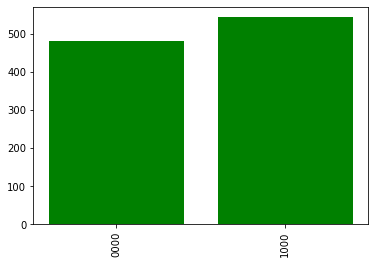

        Register Output        Phase Fraction  Guess for r  Count
0  0000(bin) =   0(dec)  0/16 = 0.00      0/1            1    481
1  1000(bin) =   8(dec)  8/16 = 0.50      1/2            2    543
-------------------------------------
Success Probability 0.5302734375
With Noise
            ┌───┐┌─────────────────────────┐┌───────┐┌─┐         
exponent_0: ┤ H ├┤0                        ├┤0      ├┤M├─────────
            ├───┤│                         ││       │└╥┘┌─┐      
exponent_1: ┤ H ├┤1                        ├┤1      ├─╫─┤M├──────
            ├───┤│                         ││  IQFT │ ║ └╥┘┌─┐   
exponent_2: ┤ H ├┤2                        ├┤2      ├─╫──╫─┤M├───
            ├───┤│                         ││       │ ║  ║ └╥┘┌─┐
exponent_3: ┤ H ├┤3                        ├┤3      ├─╫──╫──╫─┤M├
            ├───┤│                         │└───────┘ ║  ║  ║ └╥┘
  target_0: ┤ X ├┤4                        ├──────────╫──╫──╫──╫─
            └───┘│  Modular Exponentiation │          ║  ║  

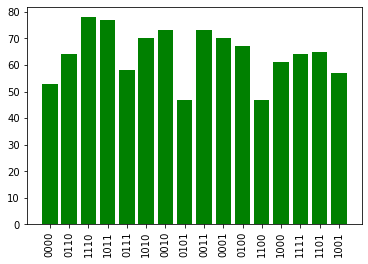

         Register Output         Phase Fraction  Guess for r  Count
0   0000(bin) =   0(dec)   0/16 = 0.00      0/1            1     53
1   0110(bin) =   6(dec)   6/16 = 0.38      1/3            3     64
2   1110(bin) =  14(dec)  14/16 = 0.88      1/1            1     78
3   1011(bin) =  11(dec)  11/16 = 0.69      2/3            3     77
4   0111(bin) =   7(dec)   7/16 = 0.44      1/2            2     58
5   1010(bin) =  10(dec)  10/16 = 0.62      2/3            3     70
6   0010(bin) =   2(dec)   2/16 = 0.12      0/1            1     73
7   0101(bin) =   5(dec)   5/16 = 0.31      1/3            3     47
8   0011(bin) =   3(dec)   3/16 = 0.19      1/3            3     73
9   0001(bin) =   1(dec)   1/16 = 0.06      0/1            1     70
10  0100(bin) =   4(dec)   4/16 = 0.25      1/3            3     67
11  1100(bin) =  12(dec)  12/16 = 0.75      2/3            3     47
12  1000(bin) =   8(dec)   8/16 = 0.50      1/2            2     61
13  1111(bin) =  15(dec)  15/16 = 0.94      1/1 

In [25]:
print('Without Noise')
p = find_order_noise_model(2, 3, 2)
print('Success Probability', p)

print('With Noise')
p = find_order_noise_model(2, 3, 2, 0.001, 0.01)
print('Success Probability', p)

Without Noise
            ┌───┐┌──────────────────────────┐┌───────┐┌─┐               
exponent_0: ┤ H ├┤0                         ├┤0      ├┤M├───────────────
            ├───┤│                          ││       │└╥┘┌─┐            
exponent_1: ┤ H ├┤1                         ├┤1      ├─╫─┤M├────────────
            ├───┤│                          ││       │ ║ └╥┘┌─┐         
exponent_2: ┤ H ├┤2                         ├┤2      ├─╫──╫─┤M├─────────
            ├───┤│                          ││  IQFT │ ║  ║ └╥┘┌─┐      
exponent_3: ┤ H ├┤3                         ├┤3      ├─╫──╫──╫─┤M├──────
            ├───┤│                          ││       │ ║  ║  ║ └╥┘┌─┐   
exponent_4: ┤ H ├┤4                         ├┤4      ├─╫──╫──╫──╫─┤M├───
            ├───┤│                          ││       │ ║  ║  ║  ║ └╥┘┌─┐
exponent_5: ┤ H ├┤5                         ├┤5      ├─╫──╫──╫──╫──╫─┤M├
            ├───┤│                          │└───────┘ ║  ║  ║  ║  ║ └╥┘
  target_0: ┤ X ├┤6                  

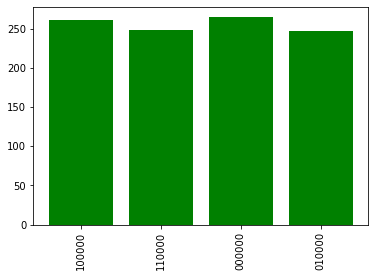

          Register Output         Phase Fraction  Guess for r  Count
0  100000(bin) =  32(dec)  32/64 = 0.50      1/2            2    262
1  110000(bin) =  48(dec)  48/64 = 0.75      3/4            4    249
2  000000(bin) =   0(dec)   0/64 = 0.00      0/1            1    265
3  010000(bin) =  16(dec)  16/64 = 0.25      1/4            4    248
-------------------------------------
Success Probability 0.4853515625
With Noise
            ┌───┐┌──────────────────────────┐┌───────┐┌─┐               
exponent_0: ┤ H ├┤0                         ├┤0      ├┤M├───────────────
            ├───┤│                          ││       │└╥┘┌─┐            
exponent_1: ┤ H ├┤1                         ├┤1      ├─╫─┤M├────────────
            ├───┤│                          ││       │ ║ └╥┘┌─┐         
exponent_2: ┤ H ├┤2                         ├┤2      ├─╫──╫─┤M├─────────
            ├───┤│                          ││  IQFT │ ║  ║ └╥┘┌─┐      
exponent_3: ┤ H ├┤3                         ├┤3      ├─╫──╫──╫

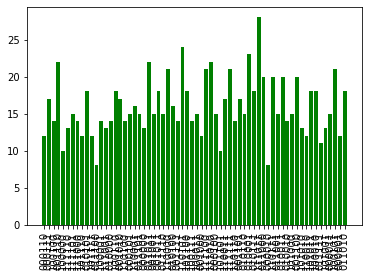

           Register Output         Phase Fraction  Guess for r  Count
0   000110(bin) =   6(dec)   6/64 = 0.09      0/1            1     12
1   000111(bin) =   7(dec)   7/64 = 0.11      1/5            5     17
2   100100(bin) =  36(dec)  36/64 = 0.56      3/5            5     14
3   001110(bin) =  14(dec)  14/64 = 0.22      1/5            5     22
4   100000(bin) =  32(dec)  32/64 = 0.50      1/2            2     10
..                     ...           ...      ...          ...    ...
59  101001(bin) =  41(dec)  41/64 = 0.64      2/3            3     13
60  000011(bin) =   3(dec)   3/64 = 0.05      0/1            1     15
61  100101(bin) =  37(dec)  37/64 = 0.58      3/5            5     21
62  000001(bin) =   1(dec)   1/64 = 0.02      0/1            1     12
63  011010(bin) =  26(dec)  26/64 = 0.41      2/5            5     18

[64 rows x 5 columns]
-------------------------------------
Success Probability 0.123046875


In [60]:
print('Without Noise')
p = find_order_noise_model(3, 5, 4)
print('Success Probability', p)
    
print('With Noise')
p = find_order_noise_model(3, 5, 4, 0.001, 0.01)
print('Success Probability', p)

# Success Probability

0.0001
0.001
0.01
0.1
0.9


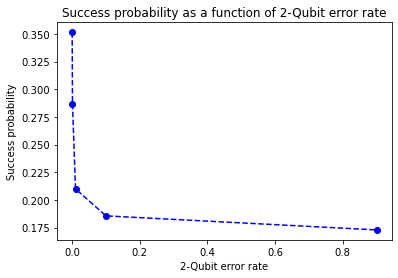

In [39]:
prob_1 = 0.001
prob_2s = [0.0001, 0.001, 0.01, 0.1, 0.9]

probs = []

for prob_2 in prob_2s:
    print(prob_2)
    p = find_order_noise_model(2, 3, 2, prob_1, prob_2, False)
    probs.append(p)

plt.plot(prob_2s, probs, '--bo')
plt.title('Success probability as a function of 2-Qubit error rate')
plt.ylabel('Success probability')
plt.xlabel('2-Qubit error rate')
plt.show() 

1e-05
0.0001
0.001
0.01
0.1
0.9


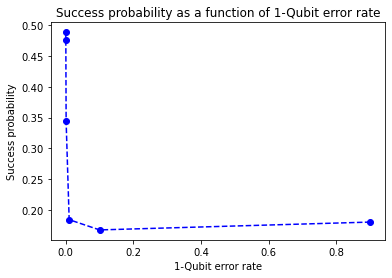

In [44]:
prob_2 = 0.0001
prob_1s = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.9]

probs = []

for prob_1 in prob_1s:
    print(prob_1)
    p = find_order_noise_model(2, 3, 2, prob_1, prob_2, False)
    probs.append(p)

plt.plot(prob_1s, probs, '--bo')
plt.title('Success probability as a function of 1-Qubit error rate')
plt.ylabel('Success probability')
plt.xlabel('1-Qubit error rate')
plt.show() 

1e-05
0.0001
0.001
0.01
0.1
0.9
1e-05
0.0001
0.001
0.01
0.1
0.9


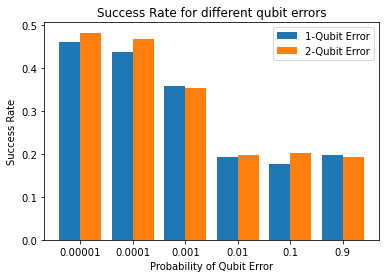

In [45]:
probs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.9]
qubit1 = []
qubit2 = []

for prob in probs:
    print(prob)
    p = find_order_noise_model(2, 3, 2, prob, 0, False)
    qubit1.append(p)
    
for prob in probs:
    print(prob)
    p = find_order_noise_model(2, 3, 2, 0, prob, False)
    qubit2.append(p)

X = ['0.00001', '0.0001', '0.001', '0.01', '0.1', '0.9']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, qubit1, 0.4, label = '1-Qubit Error')
plt.bar(X_axis + 0.2, qubit2, 0.4, label = '2-Qubit Error')

plt.xticks(X_axis, X)
plt.xlabel("Probability of Qubit Error")
plt.ylabel("Success Rate")
plt.title("Success Rate for different qubit errors")
plt.legend()
plt.show()
    

3
5
7


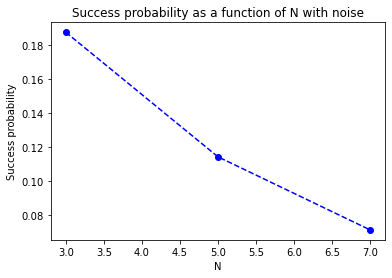

In [17]:
Ns = [3, 5, 7]
probs = []

for N in Ns:
    print(N)
    p = find_order_noise_model(2, N, 2, 0.001, 0.01, False)
    probs.append(p)

plt.plot(Ns, probs, '--bo')
plt.title('Success probability as a function of N with noise')
plt.ylabel('Success probability')
plt.xlabel('N')
plt.show() 

3
5
7


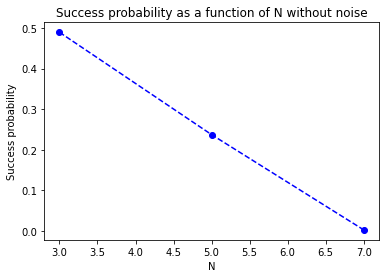

In [18]:
Ns = [3, 5, 7]
probs = []

for N in Ns:
    print(N)
    p = find_order_noise_model(2, N, 2, 0, 0, False)
    probs.append(p)

plt.plot(Ns, probs, '--bo')
plt.title('Success probability as a function of N without noise')
plt.ylabel('Success probability')
plt.xlabel('N')
plt.show() 

2
3
4


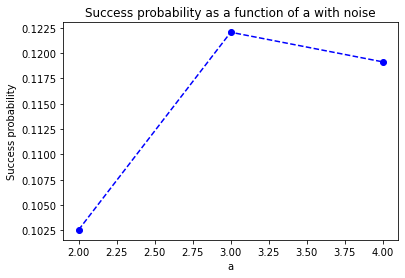

In [19]:
alist = [2, 3, 4]
probs = []

for a in alist:
    print(a)
    p = find_order_noise_model(a, 5, 2, 0.001, 0.01, False)
    probs.append(p)

plt.plot(alist, probs, '--bo')
plt.title('Success probability as a function of a with noise')
plt.ylabel('Success probability')
plt.xlabel('a')
plt.show() 

2
3
4


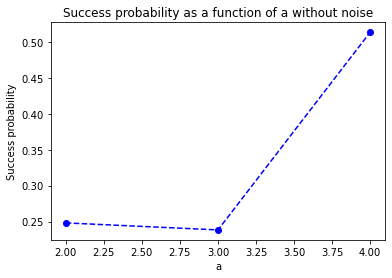

In [20]:
alist = [2, 3, 4]
probs = []

for a in alist:
    print(a)
    p = find_order_noise_model(a, 5, 2, 0, 0, False)
    probs.append(p)

plt.plot(alist, probs, '--bo')
plt.title('Success probability as a function of a without noise')
plt.ylabel('Success probability')
plt.xlabel('a')
plt.show() 

# Time vs N for given a

In [18]:
# Find Order.
def find_order_noise_model(a: int, N: int, withNoise = True, verbose:bool = True) -> Optional[int]:
    """
    Finds smallest positive r such that x**r mod n == 1.
    """

    # Check that the integer a is a valid element of the multiplicative group modulo N.
    if a < 2 or N <= a or math.gcd(a, N) > 1:
        raise ValueError(f'Find Order failed due to invalid a={a} and modulus N={N}.')
    
    # Create the order finding circuit.
    circuit = create_orderfind_circuit(a, N, verbose)
    
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend('aer_simulator')
    
    if withNoise:
        # Error probabilities
        prob_1 = 0.001  # 1-qubit gate
        prob_2 = 0.01   # 2-qubit gate

        # Depolarizing quantum errors
        error_1 = noise.depolarizing_error(prob_1, 1)
        error_2 = noise.depolarizing_error(prob_2, 2)

        # Add errors to noise model
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

        # Get basis gates from noise model
        basis_gates = noise_model.basis_gates

        # Perform a noise simulation
        result = execute(circuit, simulator,
                     basis_gates=basis_gates,
                     noise_model=noise_model).result()
    else:
        # Execute noisy simulation and get counts
        result = execute(circuit, simulator).result()
        
    # Sample from the order finding circuit.
    frequencies = result.get_counts(0)
    
    # Return the processed measurement result.
    r = continued_fraction_algorithm(frequencies, a, N)
    return r

In [19]:
def runQuantumCircuit(a: int = -1, N: int = -1, withNoise = True, verbose: bool = True, max_attempts: int = 25) -> tuple:
    """
    Runs the Quantum Circuit Portion
    """
    start = time.time()
    
    answer_found = False
    attempt = 1
    # Simulator Runs
    while attempt <= max_attempts and answer_found == False:
        r = find_order_noise_model(a, N, withNoise, verbose)
        if r is not None:
            answer_found = True
        else:
            attempt = attempt + 1
    
    end = time.time()
    avg_quant_time = (end - start) / attempt

    return (attempt, avg_quant_time, end - start)

3
5
7


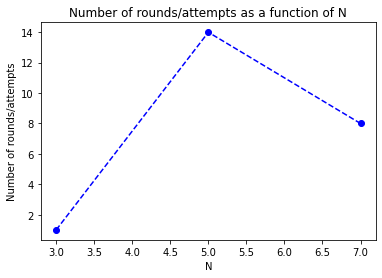

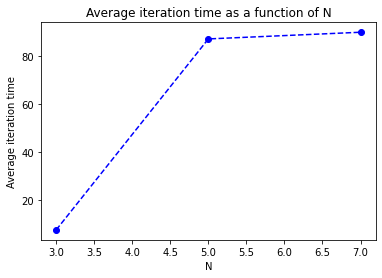

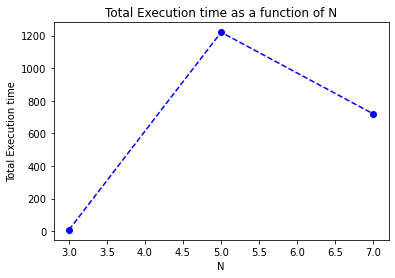

In [20]:
Ns = [3, 5, 7]
attempts = []
avg_times = []
tot_times = []

for N in Ns:
    print(N)
    (att, avg, tot) = runQuantumCircuit(2, N, True, False, 25)
    attempts.append(att)
    avg_times.append(avg)
    tot_times.append(tot)

plt.plot(Ns, attempts, '--bo')
plt.title('Number of rounds/attempts as a function of N')
plt.ylabel('Number of rounds/attempts')
plt.xlabel('N')
plt.show() 

plt.plot(Ns, avg_times, '--bo')
plt.title('Average iteration time as a function of N')
plt.ylabel('Average iteration time')
plt.xlabel('N')
plt.show() 

plt.plot(Ns, tot_times, '--bo')
plt.title('Total Execution time as a function of N')
plt.ylabel('Total Execution time')
plt.xlabel('N')
plt.show() 

# Time vs a for given N

2
3
4


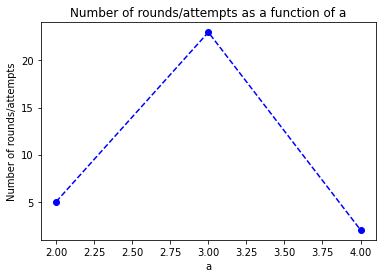

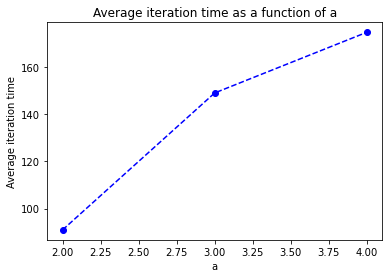

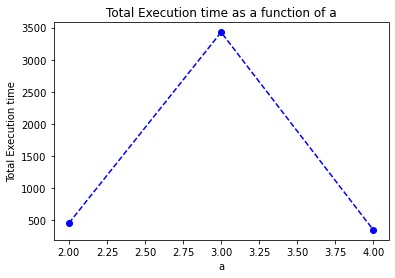

In [21]:
alist = [2, 3, 4]
attempts = []
avg_times = []
tot_times = []

for a in alist:
    print(a)
    (att, avg, tot) = runQuantumCircuit(a, 5, True, False, 25)
    attempts.append(att)
    avg_times.append(avg)
    tot_times.append(tot)

plt.plot(alist, attempts, '--bo')
plt.title('Number of rounds/attempts as a function of a')
plt.ylabel('Number of rounds/attempts')
plt.xlabel('a')
plt.show() 

plt.plot(alist, avg_times, '--bo')
plt.title('Average iteration time as a function of a')
plt.ylabel('Average iteration time')
plt.xlabel('a')
plt.show() 

plt.plot(alist, tot_times, '--bo')
plt.title('Total Execution time as a function of a')
plt.ylabel('Total Execution time')
plt.xlabel('a')
plt.show() 

# Range of time

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


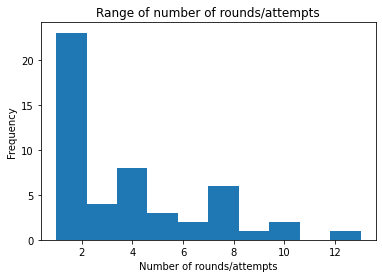

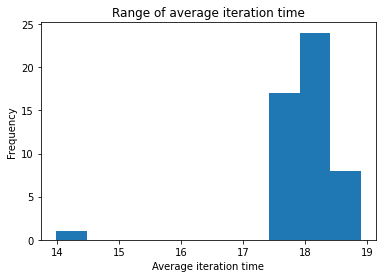

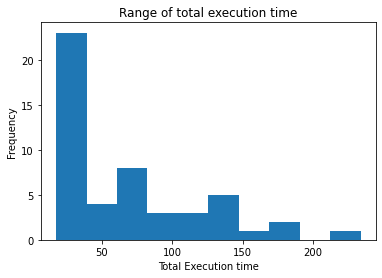

In [22]:
attempts = []
avg_times = []
tot_times = []

for i in range(50):
    print(i)
    (att, avg, tot) = runQuantumCircuit(2, 3, True, False, 25)
    attempts.append(att)
    avg_times.append(avg)
    tot_times.append(tot)

plt.hist(attempts)
plt.title('Range of number of rounds/attempts')
plt.ylabel('Frequency')
plt.xlabel('Number of rounds/attempts')
plt.show() 

plt.hist(avg_times)
plt.title('Range of average iteration time')
plt.ylabel('Frequency')
plt.xlabel('Average iteration time')
plt.show() 

plt.hist(tot_times)
plt.title('Range of total execution time')
plt.ylabel('Frequency')
plt.xlabel('Total Execution time')
plt.show() 